## Imports et preprocessing

In [37]:
import sys
from time import time
import pandas as pd
import numpy as np
from operator import itemgetter
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Où sont les listes de psis ? Elles doivent s'appeler `Psi_emul.txt` et `Psi_model.txt`.

In [22]:
path = "../Datasets/wcano/results/"

On construit
- `Psi` : dictionnaire des influences. Clés : users id, valeurs : [psi_emul, psi_model]
- `emul` : les influences données par l'émulateur, par ordre décroissant
- `model_sortby_emul` : les influences données par le modèle, triées selon l'ordre de `psi_emul`
- `model` : les influences données par le modèle, par ordre décroissant.

In [24]:
print("Chargement des Psis...")
Psi = dict()

start = time()

# emul
with open(path + "Psi_emul.txt") as psi_list:
    for i,line in enumerate(psi_list):
        line = line.split()
        current_user = int(line[0])
        current_psi = float(line[1])
        if current_psi==0:
            break
        Psi[current_user] = [current_psi, 0]

# model
with open(path + "Psi_model.txt") as psi_list:
    for i,line in enumerate(psi_list):
        line = line.split()
        current_user = int(line[0])
        current_psi = float(line[1])
        if current_psi==0:
            break
        if current_user in Psi.keys():
            Psi[current_user][-1] = current_psi
        else:
            Psi[current_user] = [0, current_psi]
            
# to arrays
emul = np.array([p[0] for p in Psi.values()])
model_sortby_emul = np.array([p[1] for p in Psi.values()])
model = - np.sort(-model_sortby_emul)

        
print("Tps ex : ", time()-start)

Chargement des Psis...
Tps ex :  8.007072925567627


In [8]:
del line, current_user, current_psi, psi_list

save len emul

In [28]:
N = len(emul)

## $\Psi_{model}$ en fonction de $\Psi_{emul}$
Exceptionnellement on prend tous les utilisateurs. On fait une régression.

In [9]:
print("Psimodel en fct de Psiemul")
start = time()

# cut extreme values
emul_to_plot = emul[:N][np.where(emul[:N]<0.01)]
model_to_plot = model_sortby_emul[:N][np.where(emul[:N]<0.01)]

# regression
reg = LinearRegression().fit(emul_to_plot.reshape(-1,1), model_to_plot.reshape(-1,1))

# print regression coeffs
intercept_str = str(np.abs(reg.intercept_[0]))[-4:]
if reg.intercept_[0] > 0:
    title = "Droite de régression : y = {:.5f}*x + {}".format(reg.coef_[0][0], intercept_str)
else:
    title = "Droite de régression : y = {:.5f}*x - {}".format(reg.coef_[0][0], intercept_str)
print(title)

# regression function for plot
def regression(x):
    return x*reg.coef_[0][0] + reg.intercept_[0]

print("Tps ex : ", time()-start)

Psimodel en fct de Psiemul
Droite de régression : y = 1.15615*x - e-09
Tps ex :  1.1170728206634521


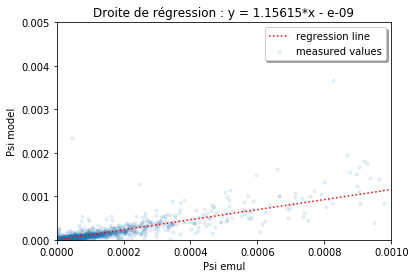

Tps ex :  226.81902194023132


In [10]:
start = time()

plt.scatter(emul_to_plot, model_to_plot, marker='.', alpha=0.1, label="measured values")
plt.plot(emul_to_plot, regression(emul_to_plot), c='r', ls=':', label="regression line")
plt.xlim(0, 0.001)
plt.ylim(0, 0.005)
# plt.xticks([k/10000 for k in range(0,21,5)])
plt.xlabel("Psi emul")
plt.ylabel("Psi model")
plt.legend(loc='best', shadow=True)
plt.title(title)
plt.savefig(path + "Psi_model_fct_psi_emul_zoom.png")
plt.show()
plt.close()

print("Tps ex : ", time()-start)

## Dataframe pour comparaison

On va comparer l'ordre des 2 listes : kendall tau, distance moyenne, proportion d'utilisateurs communs. On crée un dataframe pour enregistrer les résultats.

In [34]:
print("Creation dataframe...")

df = pd.DataFrame(columns=['N', 'min_psi_emul', 'min_psi_model', 'kendall', 'mean_dist', 'common_users_prop'])
df['N'] = range(2, N+1)
df['min_psi_emul'] = emul[1:N]
df['min_psi_model'] = model[1:N]

Creation dataframe...


In [35]:
df.head()

,N,min_psi_emul,min_psi_model,kendall,mean_dist,common_users_prop
0,2,0.007922,0.010367,NaN,NaN,NaN
1,3,0.006430,0.007884,NaN,NaN,NaN
2,4,0.006418,0.006774,NaN,NaN,NaN
3,5,0.006025,0.006212,NaN,NaN,NaN
4,6,0.004151,0.004977,NaN,NaN,NaN


## Kendall $\tau$

On calcule maintenant les kendall tau.

In [38]:
print("Kendall tau...")
kendall_tau = list()

start = time()
for i in range(2, N+1):
    sys.stdout.flush()
    sys.stdout.write("step {}... elapsed time {:.3f}\r".format(i, time()-start))
    kendall_tau.append(kendalltau(emul[:i], model_sortby_emul[:i])[0])

df['kendall'] = kendall_tau

print("Tps ex : ", time()-start)

Kendall tau...


KeyboardInterrupt: 

In [ ]:
del i, kendall_tau

Plot.

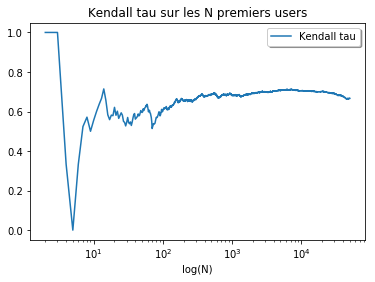

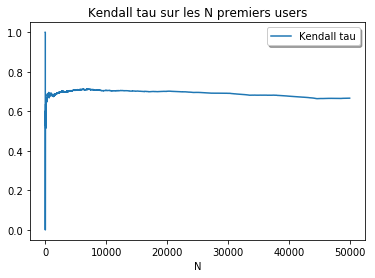

In [33]:
print("Plot kendall tau...")

plt.semilogx(range(2, N+1), df['kendall'], label="Kendall tau")
# plt.plot(range(2, N+1), [0.7]*(N-1), ls='-.', label="y = 0.7")
plt.title("Kendall tau sur les N premiers users")
plt.legend(loc='best', shadow=True)
plt.xlabel("log(N)")
plt.savefig(path + "kendall_tau_log.pdf")
plt.show()
plt.close()

plt.plot(range(2, N+1), df['kendall'], label="Kendall tau")
# plt.plot(range(2, N+1), [0.7]*(N-1), ls='-.', label="y = 0.7")
plt.title("Kendall tau sur les N premiers users")
plt.legend(loc='best', shadow=True)
plt.xlabel("N")
plt.savefig(path + "kendall_tau.pdf")
plt.show()
plt.close()

## Mean distance

Compute ranks for emul.

In [24]:
print("Mean distance...")

rank_emul = dict()
current_rank = 0
current_psi = 0

# pour chaque user on compare psi emul avec current psi et on update current rank si >
# ensuite on ajoute current rank à rank emul
for user, psi in sorted(Psi.items(), key=lambda x: x[1][0]):
    psi = psi[0] # car psi=[psi_emul,psi model]
    if psi > current_psi:
        current_rank += 1
    rank_emul[user] = current_rank
    current_psi = psi

Compute ranks for model.

In [25]:
rank_model = dict()
current_rank = 0
current_psi = 0

# pour chaque user on compare psi model avec current psi et on update current rank si >
# ensuite on ajoute current rank à rank model
for user, psi in sorted(Psi.items(), key=lambda x: x[1][1]):
    psi = psi[1] # car psi=[psi_emul,psi model]
    if psi > current_psi:
        current_rank += 1
    rank_model[user] = current_rank
    current_psi = psi

In [26]:
del psi, current_rank, current_psi

Compute mean distance.

In [27]:
# first compute distance per user
dist = list()
for user, rank in sorted(rank_emul.items(), key=itemgetter(1), reverse=True)[:N]:
    dist.append(np.abs(rank - rank_model[user]))
    
# then sums of distances
mean_dist = [ dist[0] + dist[1] ]
for d in dist[2:]:
    mean_dist.append(mean_dist[-1] + d)
    
# finally divide for mean distances
for k in range(len(mean_dist)):
    mean_dist[k] /= k+2

# add to df
df['mean_dist'] = mean_dist

In [28]:
del user, rank, d, k, dist, mean_dist

Plot.

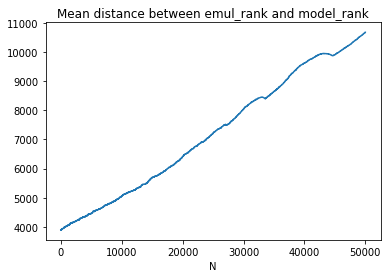

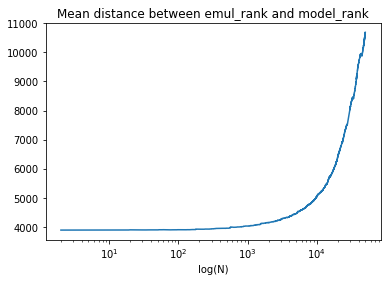

In [31]:
print("Plot mean distance...")

plt.plot(range(2, N+1), df['mean_dist'])
plt.title("Mean distance between emul_rank and model_rank")
plt.xlabel("N")
plt.savefig(path + "mean_dist.pdf")
plt.show()
plt.close()

plt.semilogx(range(2, N+1), df['mean_dist'])
plt.title("Mean distance between emul_rank and model_rank")
plt.xlabel("log(N)")
plt.savefig(path + "mean_dist_log.pdf")
plt.show()
plt.close()

## Common users proportion

In [39]:
print("Common users proportion...")

start = time()

# les liste d'utilisateurs triés par psi décroissant (emul ou model) 
# /!\ pas le même ordre
users_emul = [ user for user,psi in sorted(rank_emul.items(), key=itemgetter(1), reverse=True) ]
users_model = [ user for user,psi in sorted(rank_model.items(), key=itemgetter(1), reverse=True) ]

# les users qu'on a vu (on commence avec les 2 premiers), emul et model
seen_users_emul = set(users_emul[:2])
seen_users_model = set(users_model[:2])

# le nombre courant d'utilisateurs (uniques) qu'on a vu
nb_users_seen = len(seen_users_emul.union(seen_users_model))

# la taille de l'intersection courante et liste des proportions d'users communs
current_intersect = len(seen_users_emul.intersection(seen_users_model))
common_users_prop = [ current_intersect / nb_users_seen ]


# on parcourt les users
for n in range(2, N):
    
    # le psi emul et model
    current_user_emul = users_emul[n]
    current_user_model = users_model[n]
    
    # si les 2 users sont les mêmes alors ils sont jamais vu et intersect+1 et users_seen+1
    if current_user_emul == current_user_model:
        current_intersect += 1
        nb_users_seen += 1
        
    # sinon
    else:
        
        # si le user_emul a déjà été vu dans model ou pas
        if current_user_emul in seen_users_model:
            current_intersect += 1
        else:
            nb_users_seen += 1
        
        # si le user model a déjà été vu dans emul ou pas
        if current_user_model in seen_users_emul:
            current_intersect += 1
        else:
            nb_users_seen += 1
    
    # on update les listes
    common_users_prop.append(current_intersect / n)
    seen_users_emul.add(current_user_emul)
    seen_users_model.add(current_user_model)

    
print("Tps ex : ", time()-start)

# update df and del vars
df['common_users_prop'] = common_users_prop

Tps ex :  2.0309085845947266


In [40]:
del n, common_users_prop, seen_users_emul, seen_users_model, current_intersect, nb_users_seen

In [41]:
df.head()

,N,last_psi_emul,last_psi_model,kendall,mean_dist,common_users_prop
0,2,0.007922,0.010367,1.000000,3894.000000,0.333333
1,3,0.006430,0.007884,1.000000,3894.333333,0.200000
2,4,0.006418,0.006774,0.333333,3893.750000,0.600000
3,5,0.006025,0.006212,0.000000,3893.000000,1.000000
4,6,0.004151,0.004977,0.333333,3893.166667,0.714286


Plot.

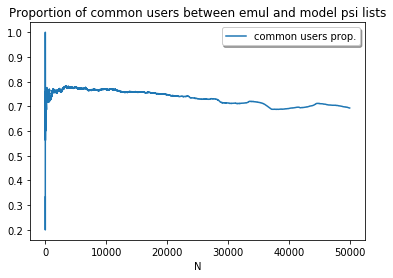

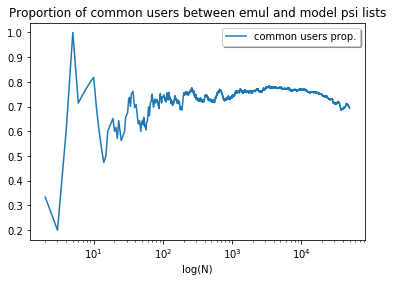

In [42]:
print("Plot common users proportion...")

plt.plot(range(2, N+1), df['common_users_prop'], label="common users prop.")
# plt.plot(range(2, N+1), [0.75]*(N-1), ls='-.', label="y = 0.75")
plt.title("Proportion of common users between emul and model psi lists")
plt.legend(loc='best', shadow=True)
plt.xlabel("N")
plt.savefig(path + "common_users_prop.pdf")
plt.show()
plt.close()

plt.semilogx(range(2, N+1), df['common_users_prop'], label="common users prop.")
# plt.plot(range(2, N+1), [0.75]*(N-1), ls='-.', label="y = 0.75")
plt.title("Proportion of common users between emul and model psi lists")
plt.legend(loc='best', shadow=True)
plt.xlabel("log(N)")
plt.savefig(path + "common_users_prop_log.pdf")
plt.show()
plt.close()

## Export dataframe

In [43]:
print("Export dataframe...")
df.to_csv(path + "compare_lists_df.txt", sep=",", index=False)